<a href="https://colab.research.google.com/github/daemonX10/AI-For-Beginners/blob/main/object_siemese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



**Siamese Network**




In [2]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.ImageOps

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [4]:
import matplotlib.pyplot as plt

In [48]:
def imshow(img,text=None):
  npimg = img.numpy()
  plt.axis("off")
  if text:
    plt.text(75,8,text,style='italic',
             fontweight='bold',bbox={'facecolor':'white',
             'alpha':0.8,'pad':10})
  plt.imshow(np.transpose(npimg,(1,2,0)))
  plt.show()

def show_plot(iteration,loss):
  plt.plot(iteration,loss)
  plt.show()

In [6]:
class SiameseNetworkDataset(Dataset):
    def __init__(self, imageFolderDataset, transform=None):
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform

    def __getitem__(self, index):
        img0_tuple = random.choice(self.imageFolderDataset.samples)  # Changed from imgs to samples

        # We need to approximately 50% of images to be in the same class
        should_get_same_class = random.randint(0, 1)
        if should_get_same_class:
            while True:
                # Look until the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.samples)  # Changed from imgs to samples
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:
            while True:
                # Look until a different class image is found
                img1_tuple = random.choice(self.imageFolderDataset.samples)  # Changed from imgs to samples
                if img0_tuple[1] != img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])

        img0 = img0.convert("L")
        img1 = img1.convert("L")

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32))

    def __len__(self):
        return len(self.imageFolderDataset.samples)  # Changed from imgs to samples

In [8]:
!wget https://github.com/maticvl/dataHacker/raw/master/DATA/at%26t.zip
!rm -rf data
!unzip "at&t.zip" -d .

--2024-07-17 18:55:40--  https://github.com/maticvl/dataHacker/raw/master/DATA/at%26t.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/maticvl/dataHacker/master/DATA/at%26t.zip [following]
--2024-07-17 18:55:41--  https://raw.githubusercontent.com/maticvl/dataHacker/master/DATA/at%26t.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3797060 (3.6M) [application/zip]
Saving to: ‘at&t.zip’

at&t.zip            100%[===================>]   3.62M  --.-KB/s    in 0.04s   

2024-07-17 18:55:41 (80.6 MB/s) - ‘at&t.zip’ saved [3797060/3797060]

Archive:  at&t.zip
   creating: ./data/
   creating: .

In [9]:
folder_dataset = datasets.ImageFolder(root='./data/faces/training/')

In [10]:
folder_dataset

Dataset ImageFolder
    Number of datapoints: 370
    Root location: ./data/faces/training/

In [11]:
transformation = transforms.Compose([transforms.Resize((100,100)),transforms.ToTensor()])

In [12]:
transformation

Compose(
    Resize(size=(100, 100), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

In [13]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,transform = transformation)

In [14]:
vis_dataloader = DataLoader(siamese_dataset,shuffle=True , num_workers=2,batch_size=8)

In [15]:
example_batch = next(iter(vis_dataloader))

In [16]:
concatenated = torch.cat((example_batch[0],example_batch[1]),0)

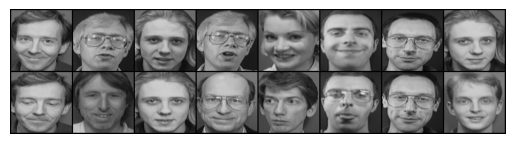

In [17]:
imshow(torchvision.utils.make_grid(concatenated))

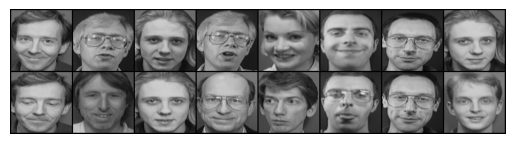

[0. 1. 0. 1. 1. 0. 0. 1.]


In [18]:
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

In [35]:
class SiamenseNetwork(nn.Module):
  def __init__(self):
    super(SiamenseNetwork,self).__init__()

    self.cnn1 = nn.Sequential(
        nn.Conv2d(1,96,kernel_size= 11 , stride=4),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(3,stride=2),

        nn.Conv2d(96,256,kernel_size=5,stride=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2,stride=2),

        nn.Conv2d(256,384,kernel_size=3,stride=1),
        nn.ReLU(inplace=True)
    )

    self.fc1= nn.Sequential(
        nn.Linear(384,1024),
        nn.ReLU(inplace=True),

        nn.Linear(1024,256),
        nn.ReLU(inplace=True),

        nn.Linear(256,2)
    )

  def forward_once(self,x):
    output = self.cnn1(x)
    output = output.view(output.size()[0],-1)
    output = self.fc1(output)
    return output

  def forward(self,input1,input2):
    output1 = self.forward_once(input1)
    output2 = self.forward_once(input2)
    return output1,output2

In [44]:
# loss
class ContrastiveLoss(torch.nn.Module):
  def __init__(self,margin=2.0):
    super(ContrastiveLoss,self).__init__()
    self.margin = margin

  def forward(self,output1,output2,label):

    euclidean_distance = F.pairwise_distance(output1,output2,keepdim=True)

    loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance,2) + (label)*torch.pow(torch.clamp(self.margin - euclidean_distance,min=0.0),2))
    return loss_contrastive

In [41]:
train_dataloader = DataLoader(siamese_dataset,shuffle=True,num_workers=8,batch_size=64)

In [45]:
net = SiamenseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr=0.0005)

In [46]:
counter = []
loss_history = []
iteration_number = 0

for epoch in range(100):
  for i , (img0,img1,label) in enumerate(train_dataloader,0):
    img0,img1,label = img0.cuda(),img1.cuda(),label.cuda()

    optimizer.zero_grad()

    output1,output2 = net(img0,img1)
    loss_contrastive = criterion(output1,output2,label)
    loss_contrastive.backward()
    optimizer.step()
    if i % 10 == 0:
      print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
      iteration_number += 10

      counter.append(iteration_number)
      loss_history.append(loss_contrastive.item())

show_plot(counter,loss_history)

Epoch number 0
 Current loss 2.059222459793091

Epoch number 1
 Current loss 1.0015709400177002

Epoch number 2
 Current loss 0.8110752105712891

Epoch number 3
 Current loss 1.0607812404632568

Epoch number 4
 Current loss 0.61458820104599

Epoch number 5
 Current loss 0.9122161269187927

Epoch number 6
 Current loss 0.7362378239631653

Epoch number 7
 Current loss 0.8158992528915405

Epoch number 8
 Current loss 0.533497154712677

Epoch number 9
 Current loss 0.6334304213523865

Epoch number 10
 Current loss 0.5022323131561279

Epoch number 11
 Current loss 0.4793163537979126

Epoch number 12
 Current loss 0.44363418221473694

Epoch number 13
 Current loss 0.5298384428024292

Epoch number 14
 Current loss 0.4600490927696228

Epoch number 15
 Current loss 0.349649041891098

Epoch number 16
 Current loss 0.3903033137321472

Epoch number 17
 Current loss 0.2817753255367279

Epoch number 18
 Current loss 0.38865381479263306

Epoch number 19
 Current loss 0.4040672481060028

Epoch number 

NameError: name 'show_plot' is not defined

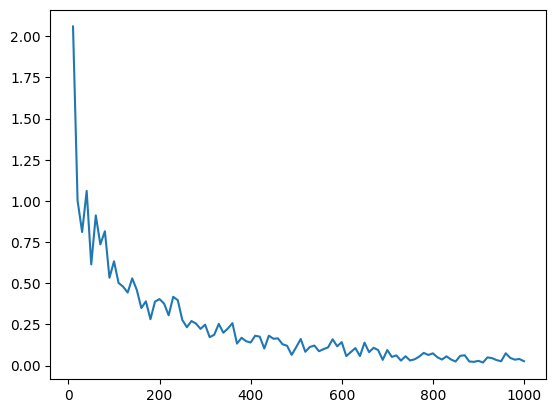

In [49]:
show_plot(counter,loss_history)

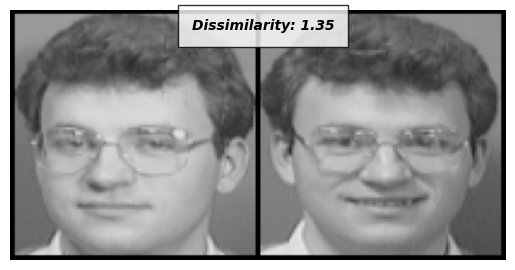

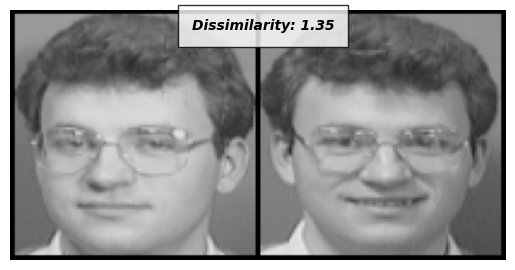

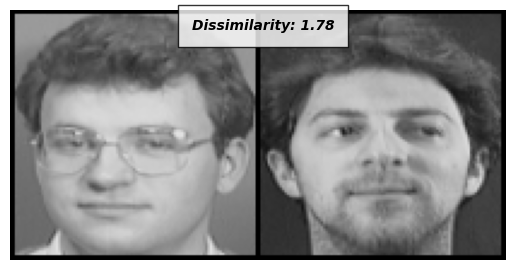

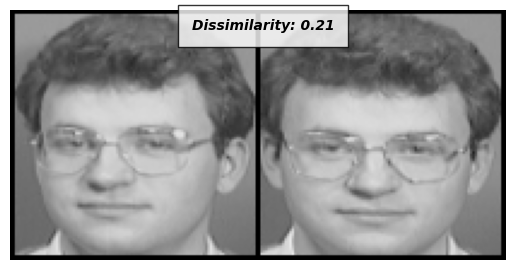

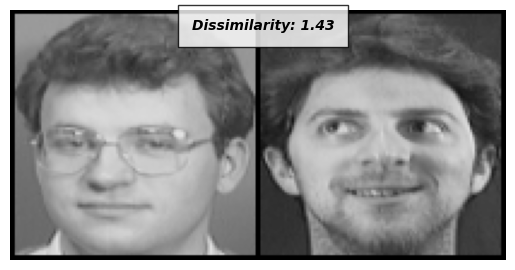

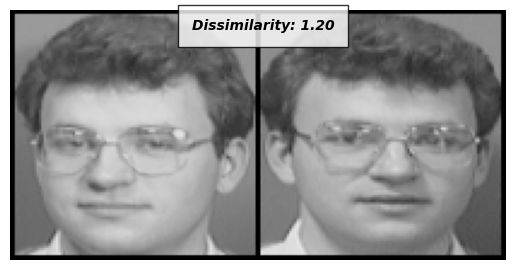

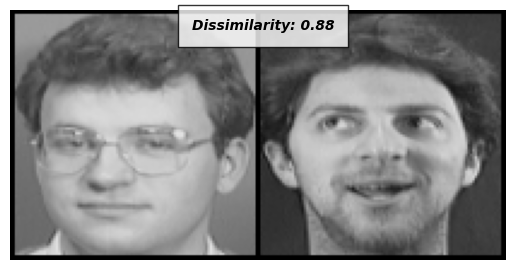

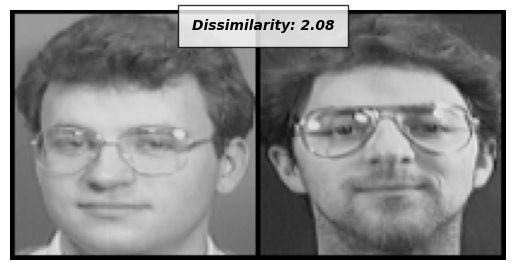

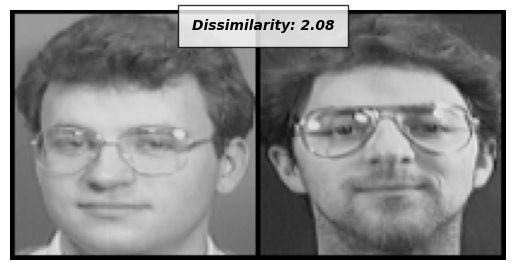

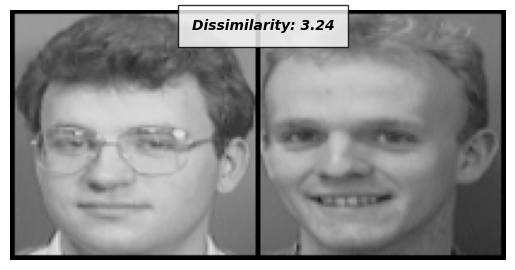

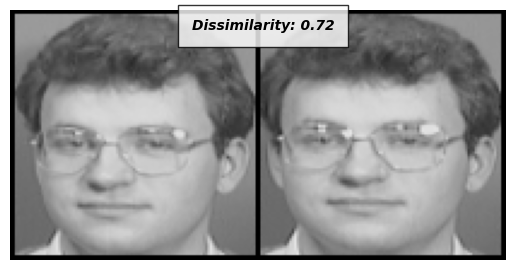

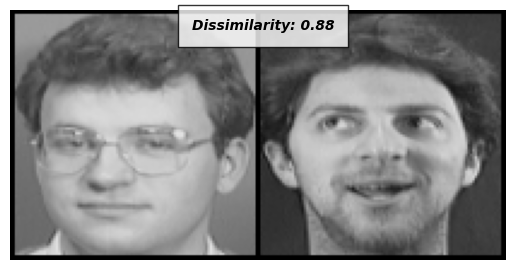

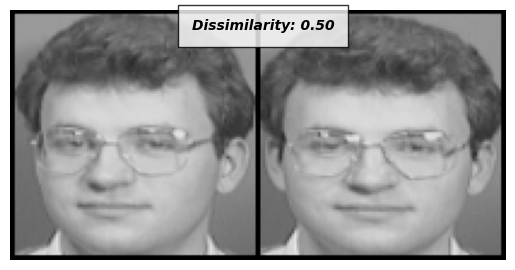

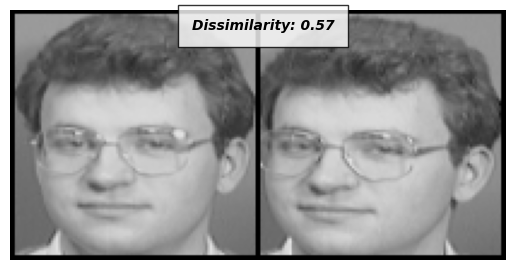

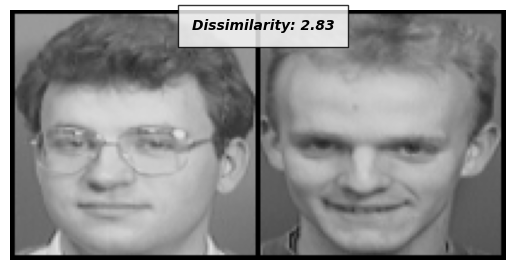

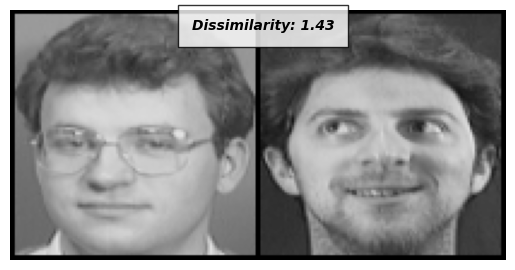

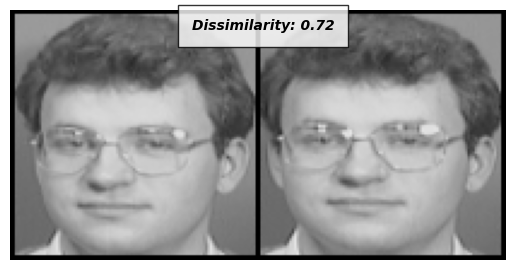

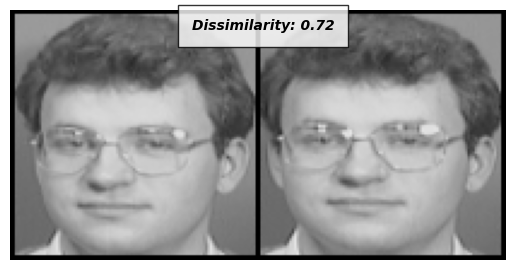

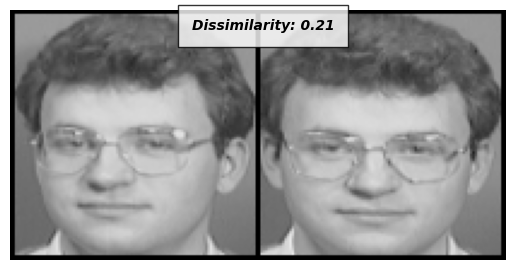

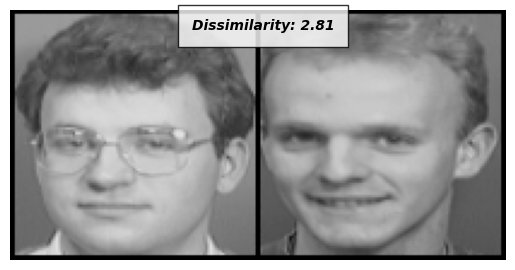

In [52]:
folder_dataset_test = datasets.ImageFolder(root='./data/faces/testing/')
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,transform = transformation)
test_dataloader = DataLoader(siamese_dataset,num_workers=2,batch_size=1,shuffle=True)

dataiter = iter(test_dataloader)
x0, _,_ = next(dataiter)

for i in range(20):
  _,x1,_ = next(dataiter)
  concatenated = torch.cat((x0,x1),0)

  output1,output2 = net(x0.cuda(),x1.cuda())
  euclidean_distance = F.pairwise_distance(output1,output2)
  imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))